# Import libraries

In [1]:
from deap import tools, base
from multiprocessing import Pool
# from ga_scheme import eaMuPlusLambda
from deap.algorithms import eaMuPlusLambda
from numpy import random as rnd
import numpy as np
from deap import creator
from deap import benchmarks

In [2]:
import sys
sys.path.append(r'C:\Users\1\Desktop\GitHub\Fedot.Industrial')
import requests
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from core.operation.transformation.WindowSelection import WindowSizeSelection
from core.models.detection.subspaces.SSTdetector import SingularSpectrumTransformation

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from tsad.evaluating.evaluating import evaluating

In [4]:
from deap import algorithms

# Data loading

In [5]:
def df_expirement():
    url = "https://storage.yandexcloud.net/cloud-files-public/dataframe.csv"
    df = pd.read_csv(StringIO(requests.get(url).content.decode('utf-8')), sep='|')
    return df

df = df_expirement()
df_columns = df.columns
first_label_list = df[df_columns[0]].unique()
df_aa564g = df[df[df_columns[0]] == first_label_list[0]]
df_aa564g_first = df_aa564g.drop(axis=1, labels=(df_aa564g.columns[0])) \
    .drop(axis=1, labels=(df_aa564g.columns[1]))[['uR/h', 'unitless']].reset_index(drop=True)
df_edited_ = df_aa564g_first.loc[df_aa564g_first['unitless'] >= 0]\
.loc[df_aa564g_first['uR/h'] >= 0].reset_index(drop=True)
df = df_edited_

cp_1 = []
for i in range(len(df)-1):
    if df['unitless'][i] !=  df['unitless'][i+1]:
        cp_1.append(1)
    else:
        cp_1.append(0)
df['change_points'] = cp_1 + [0]

ts = list(df['uR/h'])

# Model setup

In [6]:
def function(individual):
    try:
        scorer = SingularSpectrumTransformation(time_series = np.array(ts),
                                                ts_window_length = individual[0],
                                                lag = individual[1],
                                                trajectory_window_length = individual[2])
        score = scorer.score_offline(dynamic_mode=True)

        t_0 = np.arange(len(score)).astype('datetime64[s]')
        df_0 = pd.DataFrame(index=t_0, columns=['predicted_cp'])
        df_0['predicted_cp'] = np.array(score)
        df_0['true_cp'] = np.array(df.change_points)[:len(score)]

        averate_time, missed_cp, FPs, true_anomalies = evaluating(df_0['true_cp'], df_0['predicted_cp'], metric='average_time', numenta_time='30 sec')
        TP = true_anomalies - missed_cp
        precision = TP/(TP+FPs)
        recall = TP/(TP+missed_cp)
        F1 =  2*precision*recall/(precision+recall)
        return F1,
    except:
        return 0.000001,
#     return sum(individual)/len(individual),

In [7]:
creator.create("BaseFitness", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.BaseFitness)

In [8]:
toolbox = base.Toolbox()

toolbox.register("map", map)
toolbox.register("attribute", rnd.randint, 10, 250)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attribute, n=3)

toolbox.register("population", tools.initRepeat, list, toolbox.individual, 30)

# toolbox.register("population", tools.initRepeat, list, toolbox.individual, 3)


toolbox.register("mate", tools.cxOnePoint)
# toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.5, indpb=0.2)
toolbox.register("mutate", tools.mutUniformInt, 10, 250, 0.7) #класс для генерации популяции в нужном диапазоне

toolbox.register("select", tools.selTournament, tournsize=4)
toolbox.register("evaluate", function)

In [9]:
hof = tools.HallOfFame(3, np.array_equal)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [10]:
pop = toolbox.population()
pop

[[124, 165, 158],
 [27, 161, 189],
 [185, 93, 123],
 [179, 137, 41],
 [196, 49, 162],
 [78, 103, 177],
 [74, 213, 214],
 [106, 79, 217],
 [38, 175, 101],
 [69, 130, 170],
 [134, 26, 224],
 [49, 199, 190],
 [193, 194, 48],
 [80, 85, 107],
 [166, 38, 108],
 [60, 216, 147],
 [151, 26, 18],
 [116, 16, 108],
 [48, 235, 28],
 [212, 195, 196],
 [144, 165, 88],
 [10, 77, 68],
 [87, 76, 78],
 [211, 164, 167],
 [70, 37, 64],
 [215, 174, 86],
 [44, 223, 62],
 [68, 153, 192],
 [131, 236, 175],
 [239, 25, 204]]

# Model run
https://deap.readthedocs.io/en/master/api/algo.html?highlight=eaSimple#deap.algorithms.eaSimple

Intersection of scoring windows(Timestamp('1970-01-01 00:17:59'), Timestamp('1970-01-01 00:17:53'))
Intersection of scoring windows(Timestamp('1970-01-01 00:18:23'), Timestamp('1970-01-01 00:18:15'))
Intersection of scoring windows(Timestamp('1970-01-01 00:18:45'), Timestamp('1970-01-01 00:18:30'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:00'), Timestamp('1970-01-01 00:18:44'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:14'), Timestamp('1970-01-01 00:19:00'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:30'), Timestamp('1970-01-01 00:19:12'))
Intersection of scoring windows(Timestamp('1970-01-01 00:23:32'), Timestamp('1970-01-01 00:23:24'))
Intersection of scoring windows(Timestamp('1970-01-01 00:30:51'), Timestamp('1970-01-01 00:30:46'))
Intersection of scoring windows(Timestamp('1970-01-01 00:36:00'), Timestamp('1970-01-01 00:36:00'))
Intersection of scoring windows(Timestamp('1970-01-01 00:53:28'), Timestamp('1970-01-01 00:53:16'))


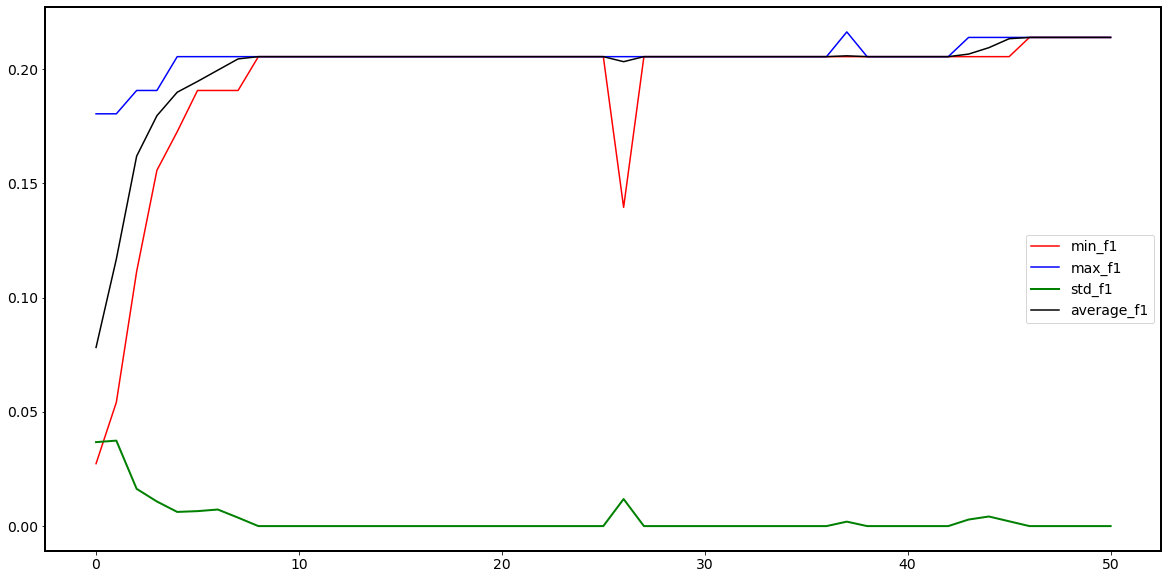

In [11]:
pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=len(pop), lambda_=int(len(pop)*0.8), cxpb=0.5, mutpb=0.2, ngen=50,
                                   stats=stats, halloffame=hof, verbose=True)

logbook_gen = [logbook[i]['gen'] for i in range(len(logbook))]
logbook_avg = [logbook[i]['avg'] for i in range(len(logbook))]
logbook_std = [logbook[i]['std'] for i in range(len(logbook))]
logbook_min = [logbook[i]['min'] for i in range(len(logbook))]
logbook_max = [logbook[i]['max'] for i in range(len(logbook))]

plt.figure(figsize=(20, 10))
plt.plot(logbook_gen, logbook_min, label = 'min_f1', color='red')
plt.plot(logbook_gen, logbook_max, label = 'max_f1', color='blue')
plt.plot(logbook_gen, logbook_std, label = 'std_f1', color='green', linewidth=2)
plt.plot(logbook_gen, logbook_avg, label = 'average_f1', color='black')
plt.legend()
plt.plot()

print("Best = {}".format(hof[0]))
print("Best fit = {}".format(hof[0].fitness.values[0]))